In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.fft import fft, fftfreq
#mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

ModuleNotFoundError: No module named 'numpy'

In [ ]:
# 目前 TF 是否使用 GPU
print("Num. GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num. GPUs Available:  1


## Functions

In [ ]:
def load_data(load_file_dir:str):
    '''讀入 csv 並存成 DataFrame'''
    return pd.read_csv(load_file_dir, header=None)

In [ ]:
def safely_mkdir(dirPath:str='', silence:bool=True):
    '''安全地生成目錄，若目錄已存在則無動作'''
    if os.path.exists(dirPath):
        if silence:
            print("Directory is exist.")
    os.makedirs(dirPath, exist_ok=True) 
    return dirPath

In [ ]:
def printlog(msg:str, dirPath:str, mode='a', sep=' ', end='\n', flush=False):
    '''用於輸出實驗參數設定至 txt file
    print to std.out and 
    write to log file at the same time'''
    print(msg, sep=sep, end=end, flush=flush)
    with open(dirPath, mode=mode) as f:
        print(msg, file=f, sep=sep, end=end, flush=flush)

In [ ]:
def MyFFT(fftInput, hamming, T):
    '''快速傅立葉變換'''
    if hamming:
        fftInput = fftInput * np.hamming(len(fftInput)) # hamming窗函數，減少頻率洩漏

    N = len(fftInput) # Number of sample points
    # T = 1.0 / 9.0 # sample spacing # 應使用傳入值T
    ## x = np.linspace(0.0, N*T, N, endpoint=False)
    y = fftInput
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    yf_regular = 2.0/N * np.abs(yf[0:N//2])


    return xf, yf_regular #*1.85 #漢明窗振幅補償

In [ ]:
def visualize_candlestick_ver1(df, show_day:np.array, SaveImgName:str):
    '''show raw data candlestick
    顏色採台灣股市風格：紅色表示漲, 綠色表示跌
    資料視覺化: Ref.: https://towardsdatascience.com/basics-of-ohlc-charts-with-pythons-matplotlib-56d0e745a5be
    Paremeter:
    * df: DataFrame (須包含 open, close, high, low)
    * show_day: array, [開始日:int, 結束日:int]
    * SaveImgName:str 圖片名稱 (不用副檔名)
    '''
    x = np.arange(0,len(df[show_day[0]:show_day[1]]))
    fig, ax = plt.subplots(1, figsize=(12,4))

    for idx, val in df[show_day[0]:show_day[1]].iterrows():   
        color = ('red' if val['open'] > val['close'] else 'green')
        # high/low lines
        plt.plot([x[idx], x[idx]], 
                [val['low'], val['high']], 
                color='black')
        # open marker
        plt.plot([x[idx], x[idx]-0.1], 
                [val['open'], val['open']], 
                color=color)
        # close marker
        plt.plot([x[idx], x[idx]+0.1], 
                [val['close'], val['close']], 
                color=color)

    # ticks: date
    #plt.xticks(x[::3], df_apple.date.dt.date[::3])
    ax.set_xticks(x, minor=True) # apply to every ticks

    # labels
    plt.ylabel('USD')

    # grid
    ax.xaxis.grid(color='black', linestyle='dashed', which='both', alpha=0.1)

    # remove spines
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)

    # title
    plt.title('IBM Stock Price', loc='left', fontsize=20)
    safely_mkdir('./img')
    plt.savefig(f'./img/{SaveImgName}.png')
    plt.show()

In [ ]:
#import mplfinance as mpf
def visualize_candlestick_ver2(df=None, type='candle', mav=[5], show_day=None):
    '''Use mpf package to show candlestick
    K 線圖 (Candlestick Chart)
    均線: moving averages with the mav keyword, [5日均線]
    ---
    Paremter:
    * df: DataFrame (須包含 open, close, high, low)
    * type: 顯示模式
    * mav: 均線
    * show_day: array, [開始日:int, 結束日:int]
    '''
    #df = df.copy()
    #df.index = pd.to_datetime(df.index, unit="D")
    #mpf.plot(df[show_day[0]:show_day[1]], type=type, mav=mav, datetime_format='%b %d')
    #print("因資料集無法獲得確切時間，因此 x 軸並非真實日期")

In [ ]:
def preprocess_add_moving_average_columns(raw_df):
    # Add MOVING AVERAGE Columns (計算日均值)
    raw_df['open-MA 5 days'] = raw_df['open'].rolling(5).mean()
    raw_df['open-MA 10 days'] = raw_df['open'].rolling(10).mean()
    raw_df['open-MA 20 days'] = raw_df['open'].rolling(20).mean()
    raw_df['open-MA 60 days'] = raw_df['open'].rolling(60).mean()
    raw_df['open-MA 120 days'] = raw_df['open'].rolling(120).mean()

    raw_df['close-MA 5 days'] = raw_df['close'].rolling(5).mean()
    raw_df['close-MA 10 days'] = raw_df['close'].rolling(10).mean()
    raw_df['close-MA 20 days'] = raw_df['close'].rolling(20).mean()
    raw_df['close-MA 60 days'] = raw_df['close'].rolling(60).mean()
    raw_df['close-MA 120 days'] = raw_df['close'].rolling(120).mean()
    
    # 移除最前面計算平均時, 因天數不足導致 MA 欄位為 NaN 的資料 
    # Removing all the NULL values using dropna() method
    raw_df.dropna(inplace=True)

    return raw_df


In [ ]:
def GenerateDataset(Raw_Data_df:pd.DataFrame, 
                    offset:int, num_features:int, columns_to_be_label:list, predict_num_days:int,
                    test_mode:bool, NewAppendData:pd.core.series.Series,
                    print_explain:bool):
    '''功能 1: 產生新的盛裝 Numpy 資料集 (用 dict 成裝, 訓練集或測試集都可製作)
    功能 2: 當輸入『現有的 numpy 資料集』及『(預測結束後) 當天的原始資料』，就能製作一筆新的 numpy 資料並 append 至現有的 numpy 資料集
    ---
    Paremeters:
    * 功能 1:
      * Raw_Data_df (DataFrame): 原始 pandas df 資料表
      * offset (int): 用於產生 input x, offset 即 lstm 的 steps,表示欲製作的 numpy 資料集，要往前看幾天份的資料 （往前看 offset 天）
      * num_features (int): 用於產生 input x, 特徵數量
      * columns_to_be_label (list of str): 用於產生 label y, 此為原始 pandas df 資料表中要選作為 label 的「欄位名稱」
      * predict_num_days (int): 預測未來幾天
    * 功能 2 (只會於 model inference 之後使用):
      * test_mode (bool): 表示現在是否為 testing 模式 (即使用功能 2)
      * NewAppendData (one sample of pd.DataFrame): 今天收盤後的「今日資料」, 用於產生新的 numpy 資料集
    * print_explain (bool): 是否要印出解釋數據？
    ---
    Returns: 
    * NumpyDataset_dict (dict of numpy arrays): 新的 Numpu Dataset
    * New_Data_df : 新的 raw data pandas 資料表 (若使用功能 2, 此表會新增一筆資料)
    '''

    if not test_mode:
      # 初始化: Numpy 資料集
      NumpyDataset_dict = {'x':np.empty(shape=(0,offset,num_features)), 'y':np.empty(shape=(0,2*predict_num_days,1))}

      # 逐筆製作 numpy 資料並 append 至 Numpy 資料集
      for date in range(1, len(Raw_Data_df)-offset-predict_num_days+1):
        # 製作一筆 x data: 每 offset 天的 features 製作成一筆 x data
        one_sample_x_np = Raw_Data_df[date:date+offset].to_numpy()
        NumpyDataset_dict['x'] = np.append(NumpyDataset_dict['x'], one_sample_x_np[np.newaxis,:], axis=0)
        # 製作一筆 y data: 將未來的？天的開盤價及收盤價製作成一筆 y data
        # 初始化: y data 
        one_sample_y_np = np.empty(shape=(0, 1))
        for future_date in range(predict_num_days):
          # 依欲預測的未來天數, 逐日取出 label data
          one_sample_y_np = np.append(one_sample_y_np, Raw_Data_df[columns_to_be_label].iloc[date+offset+future_date].to_numpy()[:,np.newaxis], axis=0)
        NumpyDataset_dict['y'] = np.append(NumpyDataset_dict['y'], one_sample_y_np[np.newaxis,:], axis=0)
    else: # is Testing mode
      # 初始化: Numpy 資料集
      NumpyDataset_dict = {'x':np.empty(shape=(0,offset,num_features))}

      # --- Preprocess 1: 轉 pandas ---
      NewAppendData = pd.DataFrame(NewAppendData).T

      # --- Preprocess 2: 欄位重新命名 ---
      NewAppendData.rename(columns={0:'open', 1:'high', 2:'low', 3:'close'}, inplace=True)

      # --- Preprocess 3: 將今日新增資料合併至 Training Data ---
      New_Data_df = pd.concat([Raw_Data_df.copy(), NewAppendData], ignore_index=True)

      # --- Preprocess 4: ---
      # * Add MOVING AVERAGE Columns (計算日均值)
      New_Data_df.loc[New_Data_df.shape[0]-1:,'open-MA 5 days'] = New_Data_df.loc[New_Data_df.shape[0]-5:New_Data_df.shape[0]-1,'open'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'open-MA 10 days'] = New_Data_df.loc[New_Data_df.shape[0]-10:New_Data_df.shape[0]-1,'open'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'open-MA 20 days'] = New_Data_df.loc[New_Data_df.shape[0]-20:New_Data_df.shape[0]-1,'open'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'open-MA 60 days'] = New_Data_df.loc[New_Data_df.shape[0]-60:New_Data_df.shape[0]-1,'open'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'open-MA 120 days'] = New_Data_df.loc[New_Data_df.shape[0]-120:New_Data_df.shape[0]-1,'open'].mean()

      New_Data_df.loc[New_Data_df.shape[0]-1:,'close-MA 5 days'] = New_Data_df.loc[New_Data_df.shape[0]-5:New_Data_df.shape[0]-1,'close'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'close-MA 10 days'] = New_Data_df.loc[New_Data_df.shape[0]-10:New_Data_df.shape[0]-1,'close'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'close-MA 20 days'] = New_Data_df.loc[New_Data_df.shape[0]-20:New_Data_df.shape[0]-1,'close'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'close-MA 60 days'] = New_Data_df.loc[New_Data_df.shape[0]-60:New_Data_df.shape[0]-1,'close'].mean()
      New_Data_df.loc[New_Data_df.shape[0]-1:,'close-MA 120 days'] = New_Data_df.loc[New_Data_df.shape[0]-120:New_Data_df.shape[0]-1,'close'].mean()

      '''
      check_for_nan = New_Data_df.isnull().values.any()
      if check_for_nan:
        print(New_Data_df)
        raise Exception(ValueError)
      '''
      '''
      print(f"old shape: {New_Data_df.shape}")
      # 移除最前面計算平均時, 因天數不足導致 MA 欄位為 NaN 的資料 
      # Removing all the NULL values using dropna() method
      New_Data_df.dropna(inplace=True)
      print(f"new shape: {New_Data_df.shape}")
      '''

      # --- 製作 Numpy Testing Dataset ---
      # 只取最後 offset 筆資料來製作成資料集 (若要製作預測未來 predict_num_days 天，則要往前取 offset + predict_num_days 天)
      
      # 製作一筆 x data: 取  offset + predict_num_days -1 天的 features 製作成一筆 x data
      one_sample_x_np = New_Data_df[-1*offset:].to_numpy()
      NumpyDataset_dict['x'] = one_sample_x_np[np.newaxis,:]
      
      '''
      try:
        NumpyDataset_dict['x'] = np.append(NumpyDataset_dict['x'], one_sample_x_np[np.newaxis,:], axis=0)
      except Exception:
        raise NameError('HiThere')
      #NumpyDataset_dict['x'] = one_sample_x_np[np.newaxis,:]
      '''
      
    
    if print_explain:
      print(f"資料集 x shpae = {NumpyDataset_dict['x'].shape}:\n" \
            f"{NumpyDataset_dict['x'].shape[0]} samples(資料筆數),\n" \
            f"{NumpyDataset_dict['x'].shape[1]} steps({offset}天),\n" \
            f"{NumpyDataset_dict['x'].shape[2]} features(特徵數量)\n")
      if not test_mode:
        print(f"資料集 y shpae = {NumpyDataset_dict['y'].shape}:\n" \
              f"{NumpyDataset_dict['y'].shape[0]} samples(資料筆數),\n" \
              f"{NumpyDataset_dict['y'].shape[1]} labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推\n" \
              f"{NumpyDataset_dict['y'].shape[2]} (開盤價/收盤價)")

    if not test_mode:
      return NumpyDataset_dict
    else:
      return NumpyDataset_dict, New_Data_df


In [ ]:
def Build_Model(input_dims, output_dims, num_output_layer, name, model_type, ):
    '''Functional API format: 
    keras functional api is a highly customizable design.
    This is Kuihao's style model builder.'''
    # Define input layer with shape 
    input_layer = tf.keras.Input(shape=input_dims) 

    # Construct NN connections
    x = input_layer # apply to input layer
    
    if model_type == 'LSTM':
        x = tf.keras.layers.LSTM(units=20, activation='relu', return_sequences=True)(x)
        x = tf.keras.layers.LSTM(units=10, activation='relu', return_sequences=False)(x)

    if model_type == 'GRU':
        x = tf.keras.layers.GRU(units=20, activation='relu', return_sequences=True)(x)
        x = tf.keras.layers.GRU(units=10, activation='relu', return_sequences=False)(x)
    
    # Concatenate other NN
    #x = tf.keras.layers.Concatenate()([x])
    
    # apply to outout layer with shape
    if num_output_layer == 1:
        output_layer = tf.keras.layers.Dense(output_dims, activation='relu')(x)
        return tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name=name)
    else:
        output_layer_1 = tf.keras.layers.Dense(output_dims, activation='relu')(x)
        output_layer_2 = tf.keras.layers.Dense(output_dims, activation='relu')(x)
        return tf.keras.Model(inputs=[input_layer], outputs=[output_layer_1, output_layer_2], name=name)
    

In [ ]:
def plot_predict(predicts, GroundTruth, savefilename, ismodel1):
    print("\n「模型預測」與「真實數值」的曲線圖:")
    plt.plot(GroundTruth, color='black') # 黑線是 Train set y 值，即隔天實際開盤價
    if ismodel1:
        plt.plot(predicts, color='orange') # 橘線是 model prediction，即模型預測的開盤價
    else:
        plt.plot(predicts[0], color='orange') # 橘線是 model prediction，即模型預測的開盤價
        plt.plot(predicts[1], color='red') # 紅線是 model prediction，即模型預測的後天開盤價
    plt.savefig(f'./img/{savefilename}.png')
    plt.show()

## Stock Strategy
買賣決策
* 提供參考: [KD指標-KD黃金交叉建議做多-死亡交叉建議做空](https://ithelp.ithome.com.tw/articles/10206894)
Inference 注意事項
* 依規定必須「輸出明日模型預測」和「讀取一天資料」**輪流進行**
* output.csv 不可以預先讀入，必須完全由 code 執行時產生並輸出

## Trader class
依範例程式，可以寫一個名為 Trader 的 class 方便助教檢驗程式<br>
此類別會實作下列方法 (method):
* train(load_training_df:pd.DataFrame, hyperparameter:list, usePreTrain:bool): 匯入訓練資料並執行 model 訓練
    * 新增參數: 
        * hyperparameter: lr, optimizer, random seed...etc
        * usePreTrain: 是否使用預訓練模型
    * load data preprocess
    * build model
    * load model
    * model training
    * model save
* predict_action(row): 依讀入的單行資料進行 model inference
    * 讀入當天資料之後，進行簡單的前處理，才進行模型預測、決策邏輯，再輸出明天的操盤行為 (action)
    * 需要將本日讀入的資料放進訓練集之中
* re_training(doReTrain:bool): 使用本日資料重新 Training
    * 新增參數:
        * doReTrain: 是否執行重新訓練

In [ ]:
class Trader():
    def __init__(self, StartDatetime_str):
        self.StartDatetime_str = StartDatetime_str # 此程式開始執行的時間，用於指定模型儲存路徑，不會用於訓練/預測
        self.raw_training_df = None # 原始匯入的 Training Data
        self.Train_set_1 = None # dict of numpy dataset (每 120 天預測未來 1 天) 
        self.Train_set_2 = None # dict of numpy dataset (每 120 天預測未來 2 天)
        self.model_1 = None # (取近期 120 天預測未來 1 天) 
        self.model_2 = None # (取近期 120 天預測未來 2 天) 
        self.Test_set = None # dict of numpy dataset (最近的 120 天，只有 x 無 y)
        self.predict1_history = [] # 畫圖用
        self.predict2_history = [] # 畫圖用

    def train(self, load_training_df:pd.DataFrame=None, 
              hyperparameter:list=None, usePreTrain:bool=True,
              choosen_model:list=[True,True]):
        '''
        Parameter:
        * load_training_df: 匯入的 training_data.csv 轉成的最原始 DataFrame
        * hyperparameter: 時間因素，並無實作 hyperparameter 參數
        * usePreTrain: bool, 是否要使用預訓練模型，預設開啟 (不會從頭開始 Training)
        * choosen_model: 要使用 model 1 (只預測明天) 還是 model 2 (預測明天+後天)，預設兩個我都要
        '''
        # --- Import raw trauining data ---
        self.raw_training_df = load_training_df

        # --- Preprocess 1: 欄位重新命名 ---
        print("Do data preprocessing and making dataset...")
        self.raw_training_df.rename(columns={0:'open', 1:'high', 2:'low', 3:'close'}, inplace=True)

        # --- Preprocess 2: ---
        # * Add MOVING AVERAGE Columns (計算日均值)
        # * 移除最前面計算平均時, 因天數不足導致 MA 欄位為 NaN 的資料 
        self.raw_training_df = preprocess_add_moving_average_columns(self.raw_training_df)

        # --- Make Dataset ---
        if choosen_model[0]:
            # [Train_set_1] 往前回推，每 120 天,預測未來 1 天
            self.Train_set_1 = GenerateDataset(self.raw_training_df,
                                            offset=120, num_features=len(self.raw_training_df.columns), 
                                            columns_to_be_label=['open','close'], predict_num_days=1,
                                            test_mode=False, NewAppendData=None,
                                            print_explain=False)
        if choosen_model[1]:
            # [Train_set_2] 往前回推，每 120 天,預測未來 2 天
            self.Train_set_2 = GenerateDataset(self.raw_training_df,
                                            offset=120, num_features=len(self.raw_training_df.columns), 
                                            columns_to_be_label=['open','close'], predict_num_days=2,
                                            test_mode=False, NewAppendData=None,
                                            print_explain=False)

        if not usePreTrain:
            print("Building and training model...")
            # --- Build Model --- 
            if choosen_model[0]:
                self.model_1 = Build_Model(input_dims=(120,14), output_dims=2, name='Stock_Price_tomorrow', 
                                           num_output_layer=1, model_type='GRU')
            if choosen_model[1]:
                self.model_2 = Build_Model(input_dims=(120,14), output_dims=2, name='Stock_Price_2_days',
                                           num_output_layer=2, model_type='GRU')
            
            myAdam =  tf.keras.optimizers.Adam(learning_rate=1e-4,)
            RMSE_loss = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
            if choosen_model[0]: self.model_1.compile(optimizer=myAdam, loss='mse',  metrics=[RMSE_loss])
            if choosen_model[1]: self.model_2.compile(optimizer=myAdam, loss='mse',  metrics=[RMSE_loss])
            
            # --- Train Model --- 
            if choosen_model[0]: 
                self.model_1.fit(self.Train_set_1['x'], 
                                self.Train_set_1['y'],
                                epochs=120,
                                batch_size=32,)
                self.model_1.save(f'./model/model1_{self.StartDatetime_str}.h5')
            if choosen_model[1]:
                self.model_2.fit(self.Train_set_2['x'], 
                                [self.Train_set_2['y'][:,:2], self.Train_set_2['y'][:,2:]],
                                epochs=150,
                                batch_size=32,)
                self.model_2.save(f'./model/model2_{self.StartDatetime_str}.h5')    
        else:
            # --- 匯入最佳模型 (pre-train model) ---
            if choosen_model[0]:
                # Load Train Model 1
                self.model_1 = tf.keras.models.load_model(f'./model/model1_2022_04_21__21_08_52.h5')
            if choosen_model[1]:
                # Load Train Model 2
                self.model_2 = tf.keras.models.load_model(f'./model/model2_2022_04_21__21_08_52.h5')

    def predict_action(self, row):
        """
        row: 今日的 IBM stock 資料 (只有一行)
        1. 對今日資料進行簡單的前處理以符合 model input dims
        2. 將今日資料合併至舊的 training dataset 以方便取最後倒數 120 天的資料
           製作出 Testing dataset
        """
        # --- Make dataset: 製作 Testing set ---
        print("Load one row test data (today stock info.)")
        print("Preporcess this one row test test data...")
        # [Test_set] 往前回推 120 天
        self.Test_set, self.raw_training_df = GenerateDataset(self.raw_training_df,
                                                offset=120, num_features=len(self.raw_training_df.columns), 
                                                columns_to_be_label=['open','close'], predict_num_days=1,
                                                test_mode=True, NewAppendData=row,
                                                print_explain=False)

        print("Model predicting...")
        predict1 = self.model_1.predict(self.Test_set['x'][-1:]) # 輸出明天開盤價、收盤價
        predict2 = self.model_2.predict(self.Test_set['x'][-1:]) # 輸出明天及後天開盤價、收盤價
        
        # 紀錄每次的預測 (用於畫圖)
        self.predict1_history.append(predict1)
        self.predict2_history.append(predict2)

        #print(predict)
        #print(self.raw_training_df.shape)

        # ----------------- #
        # 嵌入買賣決策程式碼 #
        # ---------------- #

        action = str(0) # 可輸出: 0, 1, -1
        return action

    def re_training(self, doReTrain:bool, choosen_model:list):
        """將最新取得的測試資料進行 model 二次訓練
        Paremeter:
        * doReTrain:bool  是否要 re-train
        * choosen_model:list of bool  要 re-train 的 model 填 True
        """
        if doReTrain:
            print("Re-training model via adding today one row data.")
            if choosen_model[0]:
                # 重新進行資料前處理 re-generate training dataset
                self.Train_set_1 = GenerateDataset(self.raw_training_df,
                                                   offset=120, num_features=len(self.raw_training_df.columns), 
                                                   columns_to_be_label=['open','close'], predict_num_days=1,
                                                   test_mode=False, NewAppendData=None,
                                                   print_explain=False)

                self.model_1.fit(self.Train_set_1['x'], 
                                 self.Train_set_1['y'],
                                 epochs=5, # 15
                                 batch_size=32,)
                self.model_1.save(f'./model/model1_{self.StartDatetime_str}.h5')
            if choosen_model[1]:
                # 重新進行資料前處理 re-generate training dataset
                self.Train_set_2 = GenerateDataset(self.raw_training_df,
                                    offset=120, num_features=len(self.raw_training_df.columns), 
                                    columns_to_be_label=['open','close'], predict_num_days=2,
                                    test_mode=False, NewAppendData=None,
                                    print_explain=False)

                self.model_2.fit(self.Train_set_2['x'], 
                                 [self.Train_set_2['y'][:,:2], self.Train_set_2['y'][:,2:]],
                                 epochs=10, # 20 
                                 batch_size=32,)
                self.model_2.save(f'./model/model2_{self.StartDatetime_str}.h5')


## 實驗測試 main

In [ ]:
# === import package ===

# === Functions ===

# === 環境參數設定 ===
OUTPUT_LOG = False # static global variable, 是否輸出環境參數 log 檔? (儲存於 ./log/model_XXX_XXX.txt)
FIX_RANDOM_SEED = False # static global variable, 是否要使 numpy 與 tensorflow 都套用相同的亂數種子 (seed 為隨機產生)

# Get current date and time
datetime_thisRun = datetime.now() 
datetime_thisRun_str = datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")

# numpy 與 tensorflow 設定相同的變數種子
if FIX_RANDOM_SEED:
    # 使用 random BitGenerator 隨機生出一個介於 0 ~ 2**32-1 的整數
    rng = np.random.default_rng()
    myseed = rng.integers(0b11111111111111111111111111111111, size=1) # numpy seed 為 unsign int32 
    np.random.seed(seed = myseed) # follow MT19937 by default, seed range is 0 ~ 2**32 - 1
    tf.random.set_seed(myseed)

# 儲存實驗參數
if OUTPUT_LOG:
    # Loggering dirName
    log_dirName = f'log/{datetime_thisRun_str}'
    # Make dir of Loggering
    safely_mkdir(log_dirName)
    # 紀錄 datetime
    printlog(f"Date: {datetime_thisRun}", f'{log_dirName}/log.txt')
    # 紀錄 random seed
    if OUTPUT_LOG: printlog(f"Random seed: {myseed}", f'{log_dirName}/log.txt')

# === 以下模擬 if __name__ == "__main__": 的部分 ===
# The following part is an example.
# You can modify it at will.

# 若路徑已存在 `output.csv`，刪除它，百分百保證本程式 `沒有使用到舊的 output.csv`
# If `output.csv` already exists in the path, delete it and make sure that `the program does not use the old output.csv`
try:
    os.remove('./output.csv')
except OSError as e:
    print(f"This program does not use the old output.csv!!!")

# !!!記得改回: training_data = load_data(args.training)
training_data = load_data("training_data.csv")
trader = Trader(datetime_thisRun_str) # 代入目前的時間 (datetime_thisRun_str)，純粹用於指定 model 的儲存路徑，不會用於訓練或預測
trader.train(training_data, usePreTrain=True, choosen_model=[True, True]) # choosen_model: 選擇使用 model 1 及 model 2

# !!!記得改回: testing_data = load_data(args.testing)
testing_data = load_data("testing_data.csv")
# !!!記得改回: with open(args.output, "w") as output_file:
with open("output.csv", "w") as output_file:
    for index, row in testing_data.head(len(testing_data)-1).iterrows(): # 最後一天不用輸出
        print(f"--- testing data row: {index} ---")
        # We will perform your action as the open price in the next day.
        action = trader.predict_action(row)
        output_file.write(action)
        output_file.write('\n')

        # this is your option, you can leave it empty.
        trader.re_training(doReTrain=False, choosen_model=[True, True]) # choosen_model: 選擇使用 model 1 及 model 2
print("Finish.")

Do data preprocessing and making dataset...
--- testing data row: 0 ---
Load one row test data (today stock info.)
Preporcess this one row test test data...
Model predicting...
Re-training model via adding today one row data.
Train on 1249 samples
Epoch 1/5
1249/1249 [==============================] - 4s 3ms/sample - loss: 9.2443 - root_mean_squared_error: 3.0405
Epoch 2/5
1249/1249 [==============================] - 3s 2ms/sample - loss: 9.7009 - root_mean_squared_error: 3.1146
Epoch 3/5
1249/1249 [==============================] - 3s 2ms/sample - loss: 9.2167 - root_mean_squared_error: 3.0359
Epoch 4/5
1249/1249 [==============================] - 3s 3ms/sample - loss: 9.4711 - root_mean_squared_error: 3.0775
Epoch 5/5
1249/1249 [==============================] - 3s 2ms/sample - loss: 9.1442 - root_mean_squared_error: 3.0239
Train on 1248 samples
Epoch 1/10
1248/1248 [==============================] - 3s 3ms/sample - loss: 25.5031 - dense_4_loss: 13.5529 - dense_5_loss: 11.9502 - dens


「模型預測」與「真實數值」的曲線圖:


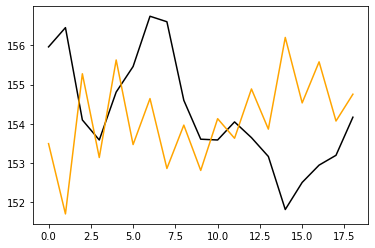

In [ ]:
#plot_predict(np.array(trader.predict1_history).squeeze().reshape(2,19)[0], testing_data[0].to_numpy()[1:], 'plot_model1_pred_open', True)


「模型預測」與「真實數值」的曲線圖:


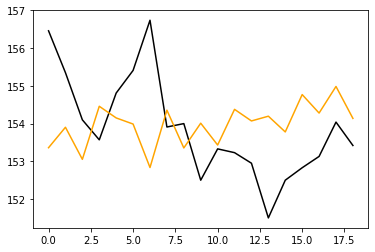

In [ ]:
#plot_predict(np.array(trader.predict1_history).squeeze().reshape(2,19)[1], testing_data[3].to_numpy()[1:], 'plot_model1_pred_close', True)


「模型預測」與「真實數值」的曲線圖:


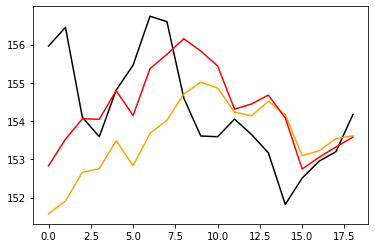

In [ ]:
#plot_predict(np.transpose(np.array(trader.predict2_history).squeeze(), (2, 1, 0))[0], testing_data[0].to_numpy()[1:], 'plot_model2_pred_open', False)


「模型預測」與「真實數值」的曲線圖:


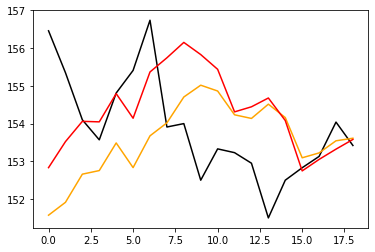

In [ ]:
#plot_predict(np.transpose(np.array(trader.predict2_history).squeeze(), (2, 1, 0))[0], testing_data[3].to_numpy()[1:], 'plot_model2_pred_close', False)

## Main
Notice: 
* 每讀完一天的資料，就必須輸出隔天是否要購買股票，輸出後才能再讀下一天的資料，以此類推。
    * E.g.:
        * D = 新的一天股票資料產生
        * A = 模型執行的動作 (-1, 0, 1)
        * 合法的順序： DADADADADA
* 違反下列規則 0 分計算:
    * 使用非法的測試資料讀取方式，E.g.: DDDDDADDA
    * 一次讀完全部股票資料才輸出是否要購買
    * 修改輸出結果
    * 輸出結果數量不正確
    * Your code is the same as other classmate’s.
    * Your Github repo does not contain your code.
    * You do not submit the homework before the deadline.
    * **The training dataset you used is not provided by TA. (言下之意，不能更改/新增 training data)** 
    * Your code can get data through the Internet during training or testing. (不能使用爬蟲) 
    * Your code terminates during testing.



In [ ]:
"""
# Functions
def load_data(load_file_dir:str):
    return pd.read_csv(load_file_dir, header=None)

# You can write code above the if-main block.

if __name__ == "__main__":
    # You should not modify this part.
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--training", default="training_data.csv", help="input training data file name")
    parser.add_argument("--testing", default="testing_data.csv", help="input testing data file name")
    parser.add_argument("--output", default="output.csv", help="output file name")
    args = parser.parse_args()

    # The following part is an example.
    # You can modify it at will.
    training_data = load_data(args.training)
    trader = Trader()
    trader.train(training_data)

    testing_data = load_data(args.testing)
    with open(args.output, "w") as output_file:
        for index, row in testing_data.iterrows():
            # We will perform your action as the open price in the next day.
            action = trader.predict_action(row)
            output_file.write(action)

            # this is your option, you can leave it empty.
            trader.re_training()
"""
print("mute")


mute
